In [7]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import random
matplotlib.rcParams['figure.figsize'] = [30, 10]
pd.options.display.max_rows = 150
pd.options.display.min_rows = 50
pd.options.display.max_columns = 20
from matplotlib.backends.backend_pdf import PdfPages


def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [17]:
hfc = pd.read_table("avarda/hfc_pubEpitopes.csv", index_col = 0,sep=',')
hfc.columns = hfc.columns.str.replace("HIV3_plate_","p")
hfc = hfc.loc[:,~hfc.columns.str.contains("BEADS_ONLY")]
wt_set = set([index.split("_")[0] for index in hfc.index])

In [388]:
ahfc = hfc.loc[~hfc.index.str.contains("mer_"),:].copy()
ahfc.loc[:,"wildtype"] = list(ahfc.index.str.split("_").str[0])
ahfc.loc[:,"scan"] = list(ahfc.index.str.split("_").str[1])
ahfc.loc[:,"sequence"] = list(ahfc.index.str.split("_").str[2])

In [389]:
ahfc = pd.melt(ahfc, id_vars=["wildtype", "scan", "sequence"], var_name="sample", value_name='hfc')
ahfc.shape

(12943037, 5)

In [390]:
# EXCLUDE SAMPLE-WILDTYPE PAIRS THAT HAVE 0 IN ALL PEPTIDES
wt_sample_aggregation = ahfc.groupby(["wildtype","sample"], as_index = False).agg({'hfc': np.max})
ahfc = ahfc.join(wt_sample_aggregation.set_index(["wildtype","sample"]), on = ["wildtype","sample"], rsuffix='_max')
ahfc = ahfc.loc[ahfc["hfc_max"]>50,:]
ahfc.shape

(407087, 6)

In [391]:
# EXCLUDE SAMPLE-WILDTYPE PAIRS THAT HAVE 0 IN WILDTYPE
wt_df = ahfc.loc[ahfc["scan"] == "wildtype",["wildtype","sample","hfc"]]
ahfc = ahfc.join(wt_df.set_index(["wildtype","sample"]), on = ["wildtype","sample"], rsuffix='_wt')
ahfc = ahfc.loc[ahfc["hfc_wt"]>30,:]
ahfc.shape

(271872, 7)

In [392]:
# EXCLUDE SAMPLE-WILDTYPE PAIRS WHERE THE WILDTYPE REACTIVITY IS NOT THE MAX REACTIVITY

wt_sample_aggregation = ahfc.groupby(["wildtype","sample"], as_index = False).agg({'hfc': percentile(90)})
ahfc = ahfc.join(wt_sample_aggregation.set_index(["wildtype","sample"]), on = ["wildtype","sample"], rsuffix='_90percentile')
ahfc = ahfc.loc[ahfc["hfc_wt"]>=ahfc["hfc_90percentile"],:]
ahfc.shape

(37858, 8)

In [393]:
# only for info how many ala_scans available
ahfc.groupby(["wildtype","sample"]).agg(max).shape

(710, 6)

In [394]:
pos_feat = pd.DataFrame(columns=["seqID", "sample", "pos", "aa", "wt_hfc", "pep_max", "ala_hfc"])
c = 0
numberofseqs = len(wt_set) #544
#numberofseqs = 10

for ix, row in ahfc.iterrows():
    if row.scan == "wildtype" :
        if c > numberofseqs-1:
            break
        c = c+1
        pos = 0
        sample = row["sample"]
        seqID = row.wildtype
        seq = row.sequence
        seq_len = len(seq)
        for aa in seq :
            idx = seqID + "_" + sample + "_" + str(pos)
            pos_feat.loc[idx, "seqID"] = seqID
            pos_feat.loc[idx, "sample"] = sample
            pos_feat.loc[idx, "pos"] = pos
            pos_feat.loc[idx, "aa"] = aa
            pos_feat.loc[idx, "wt_hfc"] = row.hfc_wt
            pos_feat.loc[idx, "pep_max"] = row.hfc_max
            pos_feat.loc[idx, "ala_hfc"] = 0
            pos = pos + 1
    else:
        aaa_pos = int(row.scan[1:])-1
        reactivity = row.hfc
        for pos_int in range(aaa_pos, aaa_pos+3):
            idx = seqID + "_" + sample + "_" + str(pos_int)
            if pos_int==0 or pos_int==seq_len-1:
                pos_feat.loc[idx, "ala_hfc"] = pos_feat.loc[idx, "ala_hfc"]  + (reactivity)
            elif pos_int==1 or pos_int==seq_len-2:
                pos_feat.loc[idx, "ala_hfc"] = pos_feat.loc[idx, "ala_hfc"]  + (reactivity/2)
            else:
                pos_feat.loc[idx, "ala_hfc"] = pos_feat.loc[idx, "ala_hfc"]  + (reactivity/3)
    
        
pos_feat["Diff_to_WT"] = pos_feat["wt_hfc"]-pos_feat["ala_hfc"]
pos_feat["Diff_to_pepMax"] = pos_feat["pep_max"]-pos_feat["ala_hfc"]

seqIDs = pos_feat.seqID.unique()

In [395]:
pos_feat.Diff_to_pepMax = pos_feat.Diff_to_pepMax.astype(float)
pos_feat.Diff_to_WT = pos_feat.Diff_to_WT.astype(float)
pos_feat.wt_hfc = pos_feat.wt_hfc.astype(float)
pos_feat.ala_hfc = pos_feat.ala_hfc.astype(float)

In [396]:
pos_feat.shape

(29632, 9)

In [28]:
#pos_feat.to_csv("ala_scan.csv")
#pos_feat = pd.read_table("ala_scan.csv", index_col = 0, sep = ",")
pos_feat["seqID"] = pos_feat["seqID"].astype(str)

In [397]:
seqIDs = pos_feat.seqID.unique()

In [99]:
# make visible per sample

matplotlib.rcParams['figure.figsize'] = [30, 8]
random_seqs = ["23325","7840","52932","53212","43135","60972","24176"]
#random_seqs = ['78394', '21455', '34792', '21029', '25319']
#random_seqs = random.choices(seqIDs, k=5)
random_seqs = seqIDs
with PdfPages('AlanineScan_DiffToWT.pdf') as pdf:
    for s in random_seqs:
        df = pos_feat[pos_feat["seqID"] == s]
        fs = pd.unique(df['sample'])[0]
        seq = list(df.loc[df["sample"] == fs, "aa"])
        plt.figure(s)
        #a = sns.lineplot(data=pos_feat[pos_feat["seqID"] == s], x='pos', y='Diff_to_pepMax', hue='sample', legend = False)
        a = sns.lineplot(data=pos_feat[pos_feat["seqID"] == s], x='pos', y='Diff_to_WT', hue='sample', legend = False)
        ax = a.twiny()
        #ax = sns.lineplot(data=pos_feat[pos_feat["seqID"] == s], x='pos', y='wt_hfc', hue='sample', legend = False)
        a.set(title = str(s))
        ax.set_xticks(range(len(seq)))
        ax.set_xticklabels(seq)
        ax.set(xlabel=None)
        pdf.savefig()
        plt.close()
    
    d = pdf.infodict()
    d['Title'] = 'Alanine Scan from Public Epitope Dataset'
    d['Author'] = 'Dr. Anna Liebhoff'
    d['Subject'] = 'Collection of vizualized Public Epitopes per Sample'
    d['CreationDate'] = datetime.datetime.today()
    d['ModDate'] = datetime.datetime.today()

In [422]:
ala_scan = pos_feat.pivot_table(index='pos',
                    columns=['seqID', 'sample'], 
                    values='Diff_to_pepMax',
                    aggfunc='first')

In [423]:
# only full length wildtypes
#ala_scan = ala_scan.loc[:,~ala_scan.loc[55,:].isna()]

In [424]:
#ala_scan = (ala_scan-ala_scan.min())/(ala_scan.max()-ala_scan.min())
ala_min = ala_scan.quantile(0.1)
ala_max = ala_scan.quantile(0.9)
ala_scan = (ala_scan-ala_min)/(ala_max-ala_min)

ala_scan = ala_scan.fillna(0)
ala_scan[ala_scan<0] = 0
ala_scan[ala_scan>1] = 1
#ala_scan.plot.line(use_index=True, y = ala_scan.columns , legend=False)


In [425]:
maxcol_cutoff = 0.9
middle_max = 0.85

def shift_cols_max(col, center):
    #print(col.loc[col==1].index)
    max_indeces = col.loc[col>maxcol_cutoff].index
    max_pos = int(np.median(max_indeces))
    return(col.shift(center-max_pos, fill_value=0))

def has_more_than_one_epitope(col):
    max_indeces = col.loc[col>maxcol_cutoff].index
    # returns true if more than one position between the outmost maxima is less than 70% of the max
    return(sum(col[max_indeces.min():max_indeces.max()+1]<middle_max)>1)

def has_only_one_epitope(col):
    max_indeces = col.loc[col>maxcol_cutoff].index
    # returns true if more than one position between the outmost maxima is less than 70% of the max
    return(sum(col[max_indeces.min():max_indeces.max()+1]<middle_max)<2)

In [426]:
ala_scan_oneEpis = ala_scan.iloc[:,[has_only_one_epitope(ala_scan[x]) for x in ala_scan.columns]]
#ala_scan_oneEpis.plot.line(use_index=True, y = ala_scan_oneEpis.columns , legend=False)
len(ala_scan_oneEpis.columns)

288

In [427]:
#ala_scan_shifted = ala_scan.apply(lambda x: shift_cols_max(x,28), axis = 0)
ala_scan_shifted = ala_scan_oneEpis.apply(lambda x: shift_cols_max(x,28), axis = 0)

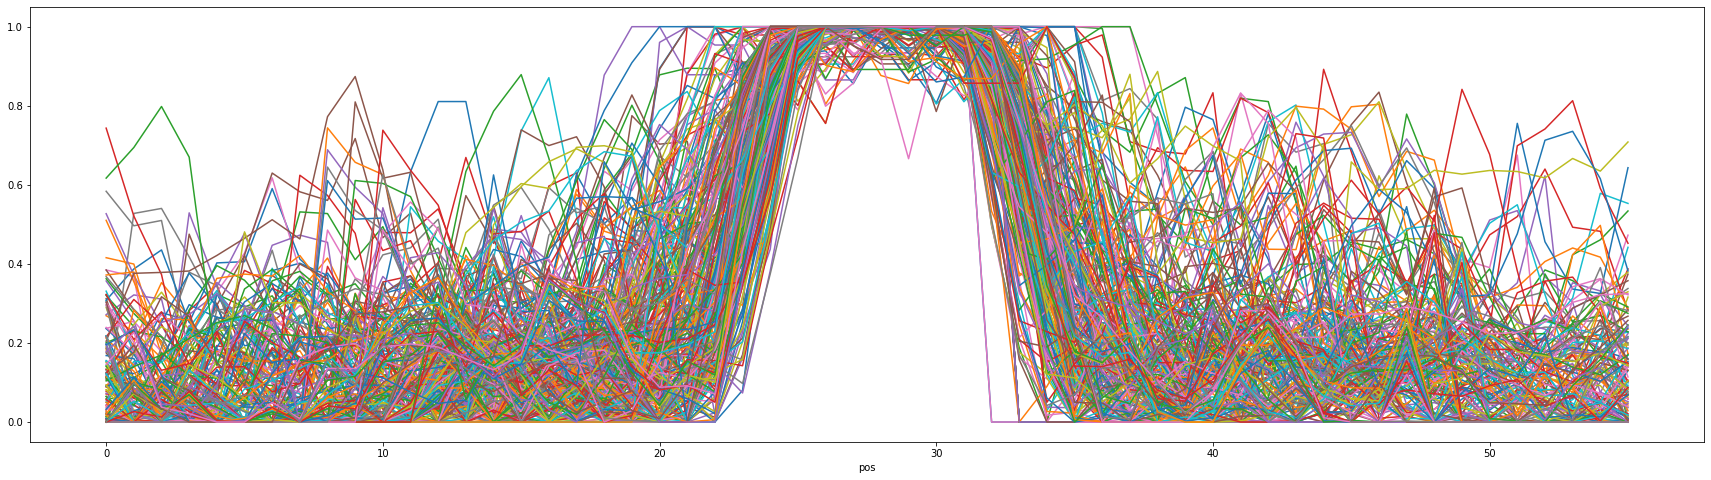

In [428]:
pt = ala_scan_shifted.plot.line(use_index=True, y = ala_scan_shifted.columns , legend=False)

width: 14


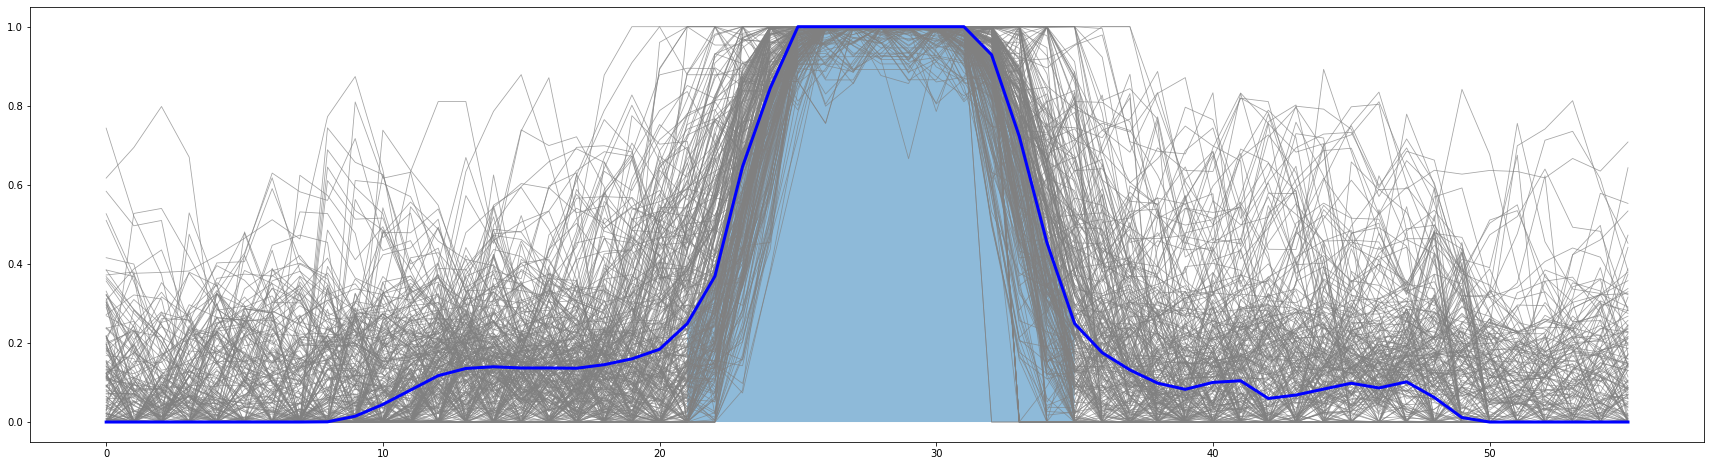

In [429]:
area_color = 0.8

for column in ala_scan_shifted:
    plt.plot(ala_scan_shifted.index, ala_scan_shifted[column], linewidth=0.8, alpha=0.7, color = "grey")
    
ala_mean = ala_scan_shifted.median(axis=1)
fullarea = np.trapz(ala_mean, dx=1)
i90 = 0
for i in range(28):
    subarea = np.trapz(ala_scan_shifted.loc[0+i:56-i,:].median(axis=1), dx=1) 
    if subarea/fullarea > area_color:
        i90 = i + 1
        
print("width:", str(56-(2*i90)))
plt.plot(ala_mean.index, ala_mean, linewidth=3,  color = "blue")
plt.fill_between(np.arange(i90, 57-i90), ala_scan_shifted.loc[i90:56-i90,:].median(axis=1), alpha=0.5)
plt.savefig("./figures/alanine_react.pdf")

plt.show()

In [311]:
ala_mean = ala_scan_shifted.mean(axis=1)
fullarea = np.trapz(ala_mean, dx=1)
i90 = 0
for i in range(28):
    subarea = np.trapz(ala_scan_shifted.loc[0+i:56-i,:].mean(axis=1), dx=1)    
    print(i, subarea/fullarea, str(56-(2*i)))
    if subarea/fullarea > 0.9:
        i90 = i + 1

0 1.0 56
1 0.9972036688709713 54
2 0.9850837516862936 52
3 0.9720492636262476 50
4 0.957982841831429 48
5 0.9435833531957569 46
6 0.9299098700191222 44
7 0.9162263685832818 42
8 0.9016821988887102 40
9 0.8854327220330693 38
10 0.8667977125260152 36
11 0.8460833356669343 34
12 0.8239077720468178 32
13 0.8005056684609666 30
14 0.7757893194910307 28
15 0.750195594066118 26
16 0.7232324106075007 24
17 0.6944095800554594 22
18 0.6632217962008872 20
19 0.629044373525283 18
20 0.5918211570203757 16
21 0.5500886151490108 14
22 0.5008582125986721 12
23 0.4416503275829733 10
24 0.3714971540593426 8
25 0.29075639430806866 6
26 0.20002125470469678 4
27 0.10190204247316735 2


In [256]:
beautiful_ala_scans = ala_scan_oneEpis.columns[(ala_scan_oneEpis>0.45).sum()<22].tolist()
beautiful_ala_scans = ala_scan_oneEpis.columns[(1-ala_scan_oneEpis.mean()) > 2*ala_scan_oneEpis.std()].tolist()
len(beautiful_ala_scans)

77

<AxesSubplot:xlabel='pos'>

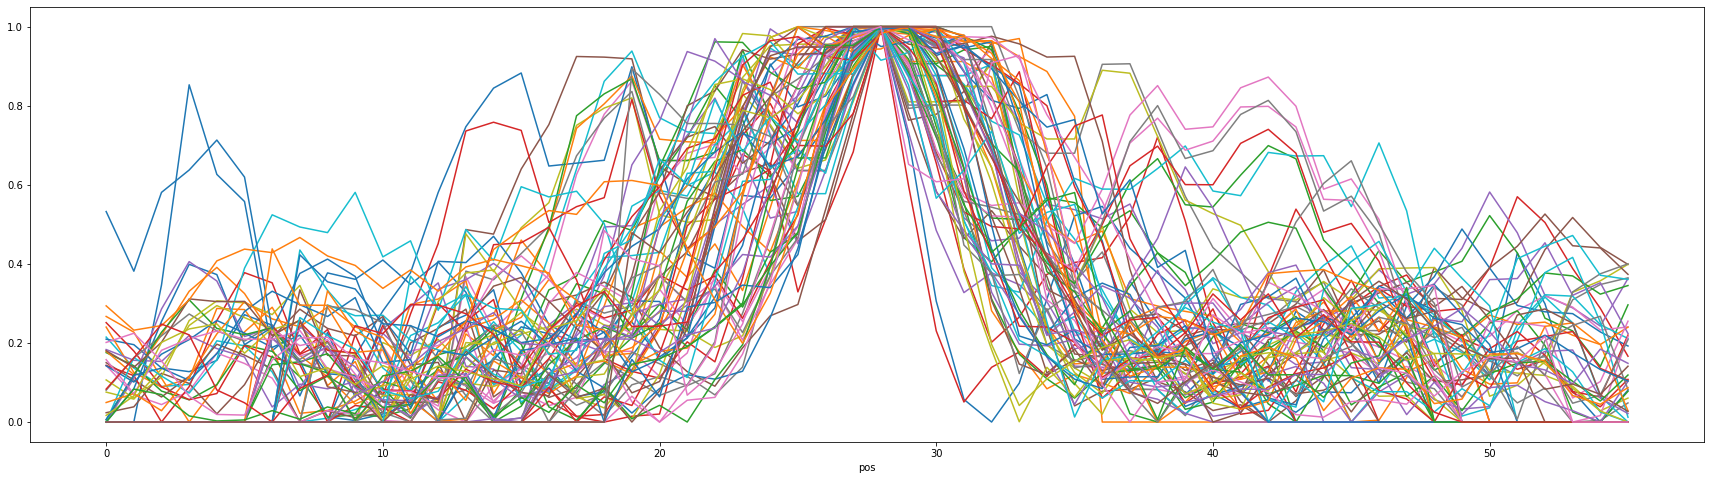

In [257]:
ala_scan_shifted.plot.line(use_index=True, y = beautiful_ala_scans, legend=False)#.figure.savefig("./figures/alanine_react_126.pdf")

In [258]:
ala_mean = ala_scan_shifted[beautiful_ala_scans].mean(axis=1)
fullarea = np.trapz(ala_mean, dx=1)
i90 = 0
for i in range(28):
    subarea = np.trapz(ala_scan_shifted.loc[0+i:56-i,beautiful_ala_scans].mean(axis=1), dx=1)    
    print(i, subarea/fullarea, str(56-(2*i)))
    if subarea/fullarea > 0.9:
        i90 = i + 1

0 1.0 56
1 0.9968758711721495 54
2 0.9882539477569178 52
3 0.9781230399220691 50
4 0.9659062418950304 48
5 0.9528609498452588 46
6 0.9397380924260467 44
7 0.9262537469662167 42
8 0.9115268697212399 40
9 0.8950970326659192 38
10 0.8777767397478009 36
11 0.8596537122588973 34
12 0.8399611149071292 32
13 0.8174282736124364 30
14 0.7933429613094105 28
15 0.7695274548595906 26
16 0.7449521793972012 24
17 0.7183084908912715 22
18 0.6885722832718398 20
19 0.6550512391838298 18
20 0.6181721520934202 16
21 0.577037974996342 14
22 0.5279001055178079 12
23 0.4674277426615431 10
24 0.3949749270820192 8
25 0.3126645660391784 6
26 0.21961171856636025 4
27 0.11434354407175043 2


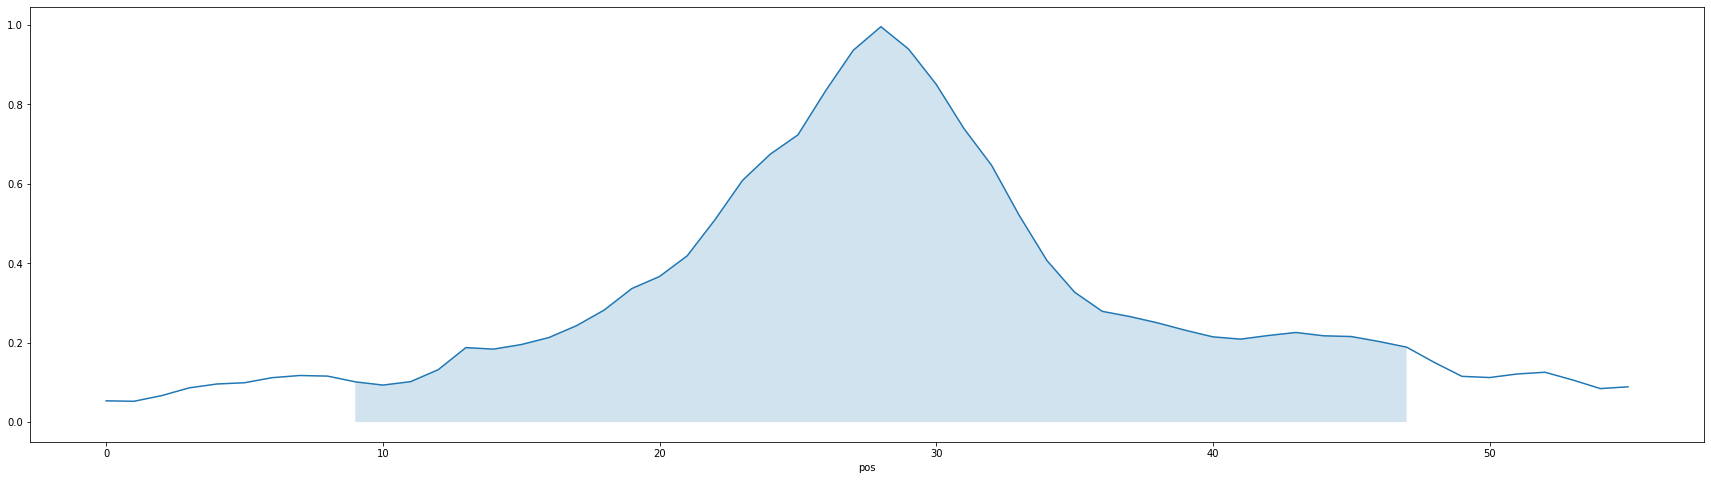

In [259]:
ala_mean.plot.line(use_index=True).fill_between(np.arange(i90, 57-i90), ala_scan_shifted.loc[i90:56-i90,beautiful_ala_scans].mean(axis=1), alpha=0.2)
#.figure.savefig("./figures/alanine_react_MEAN.pdf")